# Portfolio Analysis

In [134]:
import numpy as np
import pandas as pd
from datetime import datetime 
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [135]:
# Set up dates
purchase_date = datetime(2023, 8, 21)
sell_date = datetime(2023, 11, 20)
month_one_end_date = datetime(2023, 9, 21)
month_two_end_date = datetime(2023, 10, 21)
month_three_end_date = datetime(2023, 11, 18)

In [136]:
# Define methods
def get_stock_data(df_portfolio: pd.DataFrame) -> pd.DataFrame:
    """Get stock data from Yahoo Finance API for a list of tickers and a date range
    
    Args:
        df_portfolio: (pd.DataFrame): List of stock tickers
        
    Returns:
        pd.DataFrame: Stock data for tickers and date range
    """
    tickers = df_portfolio.index.to_list()
    stock_data: pd.DataFrame = yf.download(tickers, start=purchase_date, end=sell_date, interval="1d", auto_adjust=True, prepost=False, threads=True, proxy=None, group_by='ticker')
    
    # Set up date index for df_stock_data from Purchase_date to sell_date
    stock_data = stock_data.reindex(pd.date_range(start=purchase_date, end=sell_date, freq='D'))
    stock_data = stock_data.ffill()
    stock_data = stock_data.dropna()
    
    if len(tickers) == 1:       
        cols = pd.MultiIndex.from_tuples([
            (tickers[0],   'Open'),
            (tickers[0],   'High'),
            (tickers[0],    'Low'),
            (tickers[0],  'Close'),
            (tickers[0], 'Volume')
            ])
        stock_data.columns = cols
            
    for ticker in tickers:        
        # add new column for initial investment to df_stock_data for each group
        stock_data[ticker, 'Initial Investment'] = df_portfolio.loc[ticker, 'AMOUNT_INVESTED']
        stock_data[ticker, 'Purchase Price'] = stock_data.loc[purchase_date, (ticker, 'Close')]
        stock_data[ticker, 'Shares'] = stock_data[ticker, 'Initial Investment'] / stock_data[ticker, 'Purchase Price']
        stock_data[ticker, 'Current Value'] = stock_data[ticker, 'Shares'] * stock_data[ticker, 'Close']        
        stock_data[ticker, 'Percent Change'] = (stock_data[ticker, 'Close'] - stock_data[ticker, 'Purchase Price']) / stock_data[ticker, 'Purchase Price']
    
        
    return stock_data

def extend_portfolio_data(df_portfolio: pd.DataFrame, df_stock_data: pd.DataFrame) -> None:
    """Extend portfolio data with stock data
    
    Args:
        df_portfolio (pd.DataFrame): Portfolio data
        df_stock_data (pd.DataFrame): Stock data
        
    Returns:
        None
    """
    if 'EXPECTED_RETURN_ARR' in df_portfolio.columns:
        df_portfolio['ADJUSTED_EXPECTED_RETURN'] = df_portfolio['EXPECTED_RETURN_ARR'] / 4
    else:
        df_portfolio['EXPECTED_RETURN_ARR'] = np.NAN
        df_portfolio['ADJUSTED_EXPECTED_RETURN'] = np.NAN
    
    
    tickers = df_portfolio.index.to_list()
    for ticker in tickers:
        df_portfolio.loc[ticker, 'PURCHASE_PRICE'] = df_stock_data.loc[purchase_date, (ticker, 'Close')]
        df_portfolio.loc[ticker, 'SHARES'] = df_stock_data.loc[purchase_date, (ticker, 'Shares')]
        df_portfolio.loc[ticker, 'MONTH_1_PRICE'] = df_stock_data.loc[month_one_end_date, (ticker, 'Close')]
        df_portfolio.loc[ticker, 'MONTH_1_VALUE'] = df_stock_data.loc[month_one_end_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'MONTH_1_RETURN'] = df_stock_data.loc[month_one_end_date, (ticker, 'Current Value')] - df_stock_data.loc[purchase_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'MONTH_2_PRICE'] = df_stock_data.loc[month_two_end_date, (ticker, 'Close')]
        df_portfolio.loc[ticker, 'MONTH_2_VALUE'] = df_stock_data.loc[month_two_end_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'MONTH_2_RETURN'] = df_stock_data.loc[month_two_end_date, (ticker, 'Current Value')] - df_stock_data.loc[month_one_end_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'MONTH_3_PRICE'] = df_stock_data.loc[month_three_end_date, (ticker, 'Close')]
        df_portfolio.loc[ticker, 'MONTH_3_VALUE'] = df_stock_data.loc[month_three_end_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'MONTH_3_RETURN'] = df_stock_data.loc[month_three_end_date, (ticker, 'Current Value')] - df_stock_data.loc[month_two_end_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'ACTUAL_RETURN'] = df_stock_data.loc[month_three_end_date, (ticker, 'Current Value')] - df_stock_data.loc[purchase_date, (ticker, 'Current Value')]
        df_portfolio.loc[ticker, 'ACTUAL_RETURN_PCT'] = df_stock_data.loc[month_three_end_date, (ticker, 'Percent Change')]
        
# Function to calculate returns
def calculate_returns(df: pd.DataFrame, start: str, end: str) -> float:
    """Calculate returns for a given date range
    
    Args:
        df (pd.DataFrame): Stock data
        start (str): Start date
        end (str): End date
        
    Returns:
        float: Return for the date range        
    """
    subset = df.loc[start:end]
    start_value = subset['Current Value'].iloc[0]
    end_value = subset['Current Value'].iloc[-1]
    return (end_value - start_value) / start_value

def flatten_stock_data(df_stock_data: pd.DataFrame) -> pd.DataFrame:
    """Flatten stock data
    
    Args:
        df_stock_data (pd.DataFrame): Stock data
        
    Returns:
        pd.DataFrame: Flattened stock data
    """
    df_tmp = df_stock_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
    df_flat_stock_data = df_tmp.groupby(level=0).sum()[['Current Value']]
    return df_flat_stock_data
    

In [137]:
df_original_portfolio = pd.read_csv('../data/portfolio/original_portfolio.csv', index_col=0)
df_original_stock_prices = get_stock_data(df_original_portfolio)
extend_portfolio_data(df_original_portfolio, df_original_stock_prices)
df_flat_original_stock_prices = flatten_stock_data(df_original_stock_prices)

df_flat_original_stock_prices

[*********************100%%**********************]  5 of 5 completed


,Current Value
Date,
2023-08-21,1.000000e+06
2023-08-22,9.917681e+05
2023-08-23,1.002502e+06
2023-08-24,9.847366e+05
2023-08-25,9.978638e+05
...,...
2023-11-16,9.661726e+05
2023-11-17,9.692619e+05
2023-11-18,9.692619e+05


In [138]:
df_sentiment_portfolio = pd.read_csv('../data/portfolio/sentiment_portfolio.csv', index_col=0)
df_sentiment_stock_prices = get_stock_data(df_sentiment_portfolio)
extend_portfolio_data(df_sentiment_portfolio, df_sentiment_stock_prices)
df_flat_sentiment_stock_prices = flatten_stock_data(df_sentiment_stock_prices)

df_flat_sentiment_stock_prices

[*********************100%%**********************]  5 of 5 completed


,Current Value
Date,
2023-08-21,1000000.000000
2023-08-22,994824.872475
2023-08-23,998725.300346
2023-08-24,991552.496414
2023-08-25,999240.141714
...,...
2023-11-16,983353.375781
2023-11-17,984111.915412
2023-11-18,984111.915412


In [139]:
df_djia_portfolio = pd.read_csv('../data/portfolio/djia_portfolio.csv', index_col=0)
df_djia_prices = get_stock_data(df_djia_portfolio)
df_flat_djia_prices = flatten_stock_data(df_djia_prices)

df_flat_djia_prices

[*********************100%%**********************]  1 of 1 completed


,Current Value
Date,
2023-08-21,1.000000e+06
2023-08-22,9.949262e+05
2023-08-23,1.000270e+06
2023-08-24,9.894303e+05
2023-08-25,9.966111e+05
...,...
2023-11-16,1.013979e+06
2023-11-17,1.014032e+06
2023-11-18,1.014032e+06


In [140]:
date_ranges = [('2023-08-22', '2023-09-21'), 
               ('2023-09-22', '2023-10-21'), 
               ('2023-10-21', '2023-11-18')]

# Calculate returns for each period
returns = []
for start_date, end_date in date_ranges:
    your_return = calculate_returns(df_flat_original_stock_prices, start_date, end_date)
    sentiment_return = calculate_returns(df_flat_sentiment_stock_prices, start_date, end_date)
    returns.append((start_date, end_date, your_return, sentiment_return))

# Create DataFrame for the returns
df_returns = pd.DataFrame(returns, columns=['Start Date', 'End Date', 'Your Portfolio Return', 'Sentiment Portfolio Return'])

# Display the DataFrame
df_returns

,Start Date,End Date,Your Portfolio Return,Sentiment Portfolio Return
0,2023-08-22,2023-09-21,-0.018039,-0.016522
1,2023-09-22,2023-10-21,-0.032867,-0.034882
2,2023-10-21,2023-11-18,0.033438,0.047325


## Compare expected returns versus actual returns

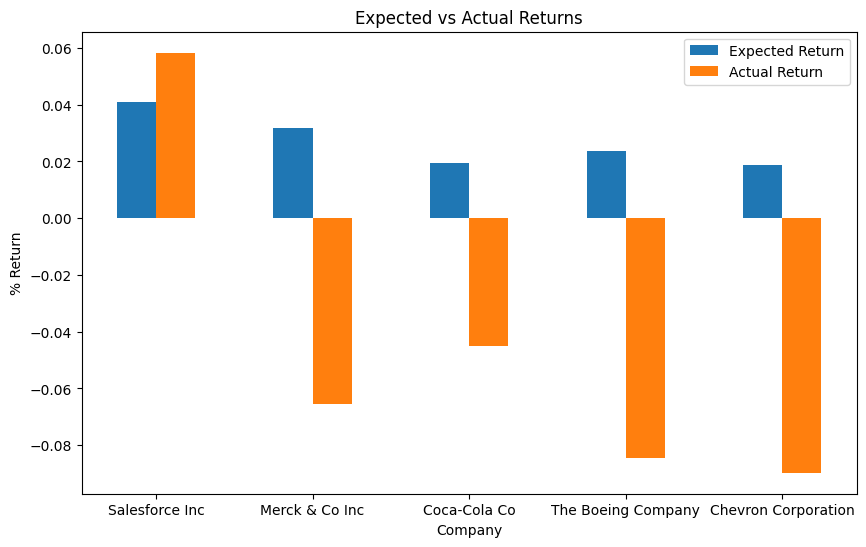

In [141]:
df_original_portfolio_returns = df_original_portfolio[['NAME', 'ADJUSTED_EXPECTED_RETURN', 'ACTUAL_RETURN_PCT']]

ind = np.arange(5)
width = 0.25
plt.figure(figsize=(10, 6))
bar1 = plt.bar(ind, df_original_portfolio_returns['ADJUSTED_EXPECTED_RETURN'], width, label='Expected Return')
bar2 = plt.bar(ind + width, df_original_portfolio_returns['ACTUAL_RETURN_PCT'], width, label='Actual Return')
plt.xlabel('Company')
plt.ylabel('% Return')
plt.title('Expected vs Actual Returns')

plt.xticks(ind + width / 2, df_original_portfolio_returns['NAME'])
plt.legend()
plt.show()

## Compare Original Portfolio vs Sentiment Portfolio

In [142]:
df_original_portfolio["PORTFOLIO"] = "ORIGINAL"
df_sentiment_portfolio["PORTFOLIO"] = "SENTIMENT"
df_combined_portfolio = pd.concat([df_original_portfolio, df_sentiment_portfolio])
df_combined_portfolio

,NAME,AMOUNT_INVESTED,EXPECTED_RETURN_ARR,ADJUSTED_EXPECTED_RETURN,PURCHASE_PRICE,SHARES,MONTH_1_PRICE,MONTH_1_VALUE,MONTH_1_RETURN,MONTH_2_PRICE,MONTH_2_VALUE,MONTH_2_RETURN,MONTH_3_PRICE,MONTH_3_VALUE,MONTH_3_RETURN,ACTUAL_RETURN,ACTUAL_RETURN_PCT,PORTFOLIO
TICKER,,,,,,,,,,,,,,,,,,
CRM,Salesforce Inc,300000.0,0.1634,0.04085,209.029999,1435.200697,208.610001,299397.218335,-602.781665,203.729996,292393.431925,-7003.786411,221.220001,317495.100004,25101.668079,17495.100004,0.058317,ORIGINAL
MRK,Merck & Co Inc,200000.0,0.1268,0.03170,108.897614,1836.587539,106.730003,196018.994176,-3981.005824,102.669998,188562.439240,-7456.554936,101.750000,186872.782067,-1689.657173,-13127.217933,-0.065636,ORIGINAL
KO,Coca-Cola Co,200000.0,0.0776,0.01940,59.954334,3335.872251,57.540001,191946.092394,-8053.907606,54.570000,182038.547736,-9907.544658,57.259998,191012.039510,8973.491775,-8987.960490,-0.044940,ORIGINAL
BA,The Boeing Company,150000.0,0.0946,0.02365,227.220001,660.153152,199.949997,131997.620725,-18002.379275,180.039993,118853.969051,-13143.651674,208.039993,137338.257307,18484.288256,-12661.742693,-0.084412,ORIGINAL
CVX,Chevron Corporation,150000.0,0.0752,0.01880,158.696472,945.200596,163.476364,154517.956734,4517.956734,165.099350,156052.003917,1534.047182,144.460007,136543.684375,-19508.319542,-13456.315625,-0.089709,ORIGINAL
WMT,Walmart Inc.,200000.0,NaN,NaN,157.509995,1269.760694,161.919998,205599.649312,5599.649312,158.759995,201587.200868,-4012.448444,155.350006,197257.331625,-4329.869243,-2742.668375,-0.013713,SENTIMENT
DOW,Dow Inc.,200000.0,NaN,NaN,53.483559,3739.466951,51.000000,190712.814490,-9287.185510,48.990002,183196.492196,-7516.322295,51.700001,193330.444209,10133.952013,-6669.555791,-0.033348,SENTIMENT
HD,Home Depot Inc.,200000.0,NaN,NaN,322.003754,621.110772,306.760010,190531.946461,-9468.053539,286.410004,177892.338462,-12639.608000,307.269989,190848.700066,12956.361604,-9151.299934,-0.045756,SENTIMENT
KO,Coca-Cola Company,200000.0,NaN,NaN,59.954334,3335.872251,57.540001,191946.092394,-8053.907606,54.570000,182038.547736,-9907.544658,57.259998,191012.039510,8973.491775,-8987.960490,-0.044940,SENTIMENT


In [143]:
df_combined_portfolio.groupby('PORTFOLIO').sum()[['MONTH_1_RETURN','MONTH_2_RETURN','MONTH_3_RETURN','ACTUAL_RETURN', 'ACTUAL_RETURN_PCT']]

,MONTH_1_RETURN,MONTH_2_RETURN,MONTH_3_RETURN,ACTUAL_RETURN,ACTUAL_RETURN_PCT
PORTFOLIO,,,,,
ORIGINAL,-26122.117636,-35977.490496,31361.471395,-30738.136737,-0.226379
SENTIMENT,-21611.351785,-38745.114337,44468.381535,-15888.084588,-0.079440


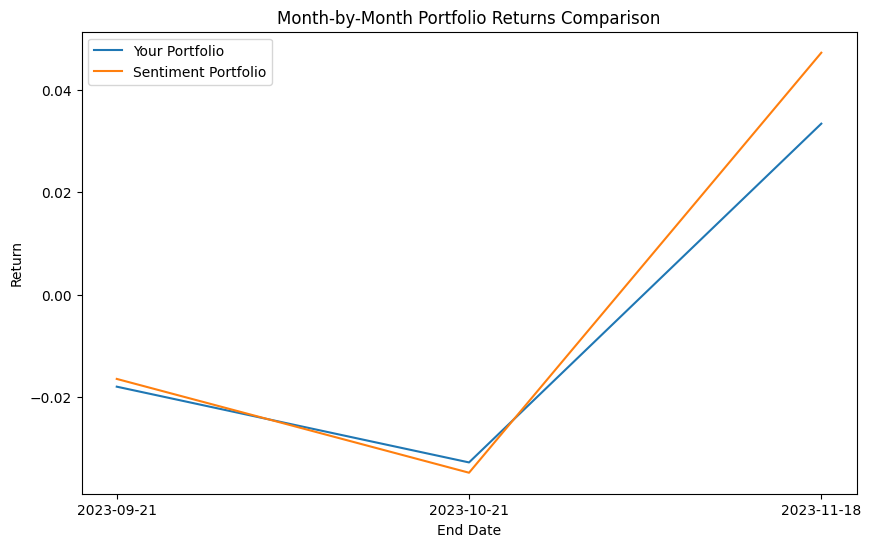

In [144]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_returns['End Date'], df_returns['Your Portfolio Return'], label='Your Portfolio')
plt.plot(df_returns['End Date'], df_returns['Sentiment Portfolio Return'], label='Sentiment Portfolio')
plt.xlabel('End Date')
plt.ylabel('Return')
plt.title('Month-by-Month Portfolio Returns Comparison')
plt.legend()
plt.show()

In [145]:
fig = go.Figure(
    [go.Scatter(x=df_flat_sentiment_stock_prices.index, y=df_flat_sentiment_stock_prices['Current Value'], name='Sentiment Portfolio'),
     go.Scatter(x=df_flat_original_stock_prices.index, y=df_flat_original_stock_prices['Current Value'], name='Team 6 Original Portfolio'),
     go.Scatter(x=df_flat_djia_prices.index, y=df_flat_djia_prices['Current Value'], name='DJIA')]
)
fig.update_layout(    
    xaxis_title='Date',
    yaxis_title='Portfolio Value'
)
fig.show()